# Content analysis
## Set-up, clean-up

# TO DO
- Import data
- Write cleaning function, apply to every df
- Add circle.png as a mask for word cloud + use pyldavis layout&size to plot the topics together
- Make word cloud topic model for Chinese
- Prettify the frequency plot for most used tokens
- Make a pretty frequency plot of language distribution in data 

Inspired by: https://github.com/chuachinhon/twitter_state_trolls_cch


In [2]:
# import data
import pandas as pd
en_df = pd.read_csv('data/english_preprocessed.csv')
zh_df = pd.read_csv('data/chinese_preprocessed.csv')

In [44]:
# setting up matplotlib settings
# Source: https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.font_manager as font_manager

# font
font_dirs = ['/Library/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

plt.rcParams['font.family'] = 'DIN Condensed Bold'

# set matplotlib aesthetics
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

sns.set(rc={
            'axes.axisbelow': False,
            'axes.edgecolor': 'lightgrey',
            'axes.facecolor': 'None',
            'axes.grid': False,
            'axes.labelcolor': 'dimgrey',
            'axes.spines.right': False,
            'axes.spines.top': False,
            'figure.facecolor': 'white',
            'lines.solid_capstyle': 'round',
            'patch.edgecolor': 'w',
            'patch.force_edgecolor': True,
            'text.color': 'dimgrey',
            'xtick.bottom': False,
            'xtick.color': 'dimgrey',
            'xtick.direction': 'out',
            'xtick.top': False,
            'ytick.color': 'dimgrey',
            'ytick.direction': 'out',
            'ytick.left': False,
            'ytick.right': False})

sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

In [4]:
# cleaning up
import re

def clean_tweet(row):
    text = row['text']
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    return text

en_df['text_clean'] = en_df.apply(clean_tweet, axis = 1)
zh_df['text_clean'] = zh_df.apply(clean_tweet, axis = 1)

In [50]:
zh_df.head()

,Unnamed: 0,created_at,id,id_str,text,retweet_count,favorite_count,lang,follower_count,tokens,text_clean
0,0,2020-05-19 14:50:34,1262757544990138369,1262757544990138369,5月18日，中国、俄罗斯、伊朗、巴基斯坦举行视频会议，就阿富汗当前局势以及和平和解进程等深入交换意见。会议由俄方主持。作为会议成果，四方发表了联合声明。四方欢迎阿富汗两位主要政治领导人签署政治协议，呼吁阿富汗各方抓住机遇，早日开启阿人内部谈判，尽早实现全面、可持续和平。 https://t.co/BA0vU1LpPS,0,0,zh,621500,"{'n_sent': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 3, 55: 3, 56: 3, 57: 3, 58: 3, 59: 3, 60: 3, 61: 3, 62: 3, 63: 3, 64: 3, 65: 3, 66: 3, 67: 3, 68: 3, 69: 3, 70: 3, 71: 3, 72: 3, 73: 3, 74: 3, 75: 3, 76: 3, 77: 3, 78: 3, 79: 3, 80: 4, 81: 4, 82: 4, 83: 4, 84: 4, 85: 4, 86: 4}, 'token': {0: '5', 1: '月', 2: '18', 3: '日', 4: '，', 5: '中国', 6: '、', 7: '俄罗斯', 8: '、', 9: '伊朗', 10: '、', 11: '巴基斯坦', 12: '举行', 13: '视频', 14: '会议', 15: '，', 16: '就', 17: '阿富汗', 18: '当前', 19: '局势', 20: '以及', 21: '和平', 22: '和解', 23: '进程', 24: '等', 25: '深入', 26: '交换', 27: '意见', 28: '。', 29: '会议', 30: '由', 31: '俄方', 32: '主持', 33: '。', 34: '作', 35: '为', 36: '会议', 37: '成果', 38: '，', 39: '四...",5月18日 中国 俄罗斯 伊朗 巴基斯坦举行视频会议 就阿富汗当前局势以及和平和解进程等深入交换意见 会议由俄方主持 作为会议成果 四方发表了联合声明 四方欢迎阿富汗两位主要政治领导人签署政治协议 呼吁阿富汗各方抓住机遇 早日开启阿人内部谈判 尽早实现全面 可持续和平
1,1,2020-05-19 14:58:12,1262759466501468160,1262759466501468160,世界卫生大会决议草案与澳大利亚提出的“独立国际审议”完全不是一回事。决议草案提出的是适时启动评估而非立即搞所谓“审议”，确认了世卫组织的关键领导作用而非另起炉灶，要求回顾总结在世卫组织协调下国际卫生领域应对工作的经验教训，而非针对个别国家搞有罪推定式的调查。澳方不要想当然地作出结论。 https://t.co/iEb7HRL2oL,0,0,zh,621505,"{'n_sent': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 2, 79: 2, 80: 2, 81: 2, 82: 2, 83: 2, 84: 2, 85: 2, 86: 3, 87: 3, 88: 3, 89: 3, 90: 3, 91: 3}, 'token': {0: '世界', 1: '卫生', 2: '大会', 3: '决议', 4: '草案', 5: '与', 6: '澳大利亚', 7: '提出', 8: '的', 9: '“', 10: '独立', 11: '国际', 12: '审议', 13: '”', 14: '完全', 15: '不是', 16: '一', 17: '回事', 18: '。', 19: '决议', 20: '草案', 21: '提出', 22: '的', 23: '是', 24: '适时', 25: '启动', 26: '评估', 27: '而', 28: '非', 29: '立即', 30: '搞', 31: '所', 32: '谓', 33: '“', 34: '审议', 35: '”', 36...",世界卫生大会决议草案与澳大利亚提出的 独立国际审议 完全不是一回事 决议草案提出的是适时启动评估而非立即搞所谓 审议 确认了世卫组织的关键领导作用而非另起炉灶 要求回顾总结在世卫组织协调下国际卫生领域应对工作的经验教训 而非针对个别国家搞有罪推定式的调查 澳方不要想当然地作出结论
2,2,2020-05-19 14:59:05,1262759687956557826,1262759687956557826,5月18日，第73届世卫大会主席宣布此次大会不讨论个别国家提出的所谓“邀请台湾地区以观察员身份参加世卫大会”的提案。台湾当局及个别国家在本次世卫大会推动涉台提案的图谋没有得逞。事实再次证明，“台独”没有出路，在世卫大会炒作涉台提案问题不得人心。 https://t.co/k9UfXPHmX6,0,0,zh,621506,"{'n_sent': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 2, 54: 2, 55: 2, 56: 2, 57: 2, 58: 2, 59: 2, 60: 2, 61: 2, 62: 2, 63: 2, 64: 2, 65: 2, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 3, 74: 3, 75: 3, 76: 3, 77: 3, 78: 3, 79: 3}, 'token': {0: '5', 1: '月', 2: '18', 3: '日', 4: '，', 5: '第73', 6: '届', 7: '世卫', 8: '大会', 9: '主席', 10: '宣布', 11: '此次', 12: '大会', 13: '不', 14: '讨论', 15: '个别', 16: '国家', 17: '提出', 18: '的', 19: '所', 20: '谓', 21: '“', 22: '邀请', 23: '台湾', 24: '地区', 25: '以', 26: '观察', 27: '员', 28: '身份', 29: '参加', 30: '世卫', 31: '大会', 32: '”', 33: '的', 34: '提案', 35: '。

In [19]:
pd.options.display.max_colwidth = 1000
print(en_df['text_clean'].sample(n=15))

8842                   guljamal  24  works as a property agent in aksu  a central city in china s xinjiang uygur autonomous region  she enjoys a busy life and makes friends with people from different ethnic groups   everyone is free to choose a different lifestyle   she said   xinjiang  
19605                  the imports of goods and services from the us slowed due to the  covid19 pandemic  lack of market supply and demand  and the us  export controls on some goods  ning said  hoping that firms on both sides work together to overcome difficulties and expand cooperation 
14907                                                                                                                  on monday  technical lead for  who s health emergencies programme maria van kerkhove said children under 10 react differently to  covid19 compared to children over 10   
20009                          has  china won the war on  poverty    over the past 5 years  china has lifted over 70 million people o

## Visualisations
### Frequent terms
#### English

/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/yellowbrick/base.py:259: DeprecationWarning: this method is deprecated, please use show() instead
  "this method is deprecated, please use show() instead", DeprecationWarning


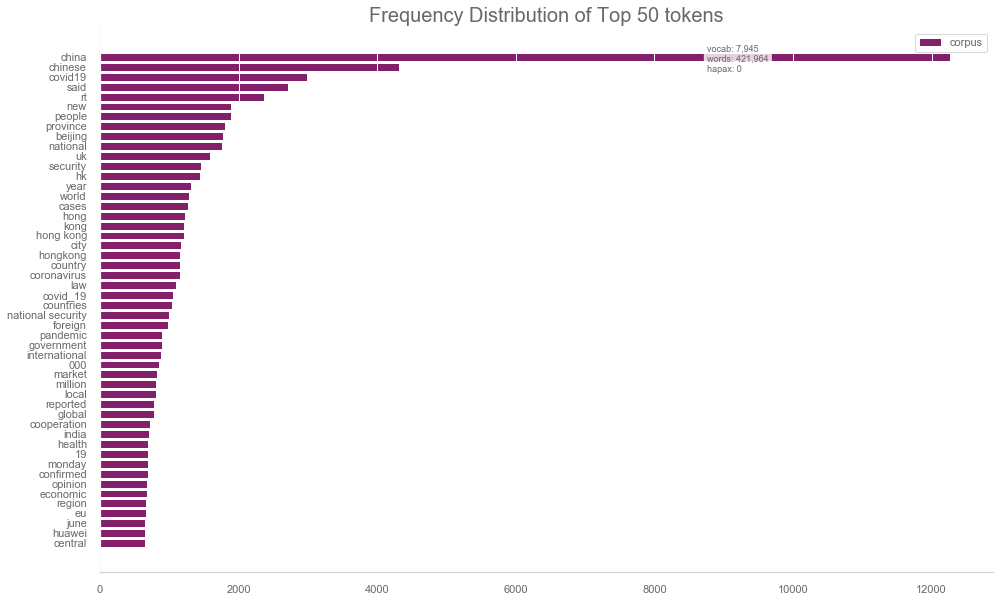

In [47]:
# Visualize frequent terms
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer
from palettable.matplotlib import Inferno_20


# clean text
vect = CountVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
docs = vect.fit_transform(en_df['text_clean'].dropna())
features = vect.get_feature_names()

plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features, show = False, color='#84206b')
visualiser.fit(docs)

visualiser.poof('plots/english/top50.png')
#visualiser.poof()

#plt.show()
#plt.savefig('plots/english/top50.png')

#### Chinese

You should consider upgrading via the '/Users/anitakurm/anaconda3/envs/text_to_x/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/yellowbrick/base.py:259: DeprecationWarning: this method is deprecated, please use show() instead
  "this method is deprecated, please use show() instead", DeprecationWarning
/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36817 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20896 missing fro

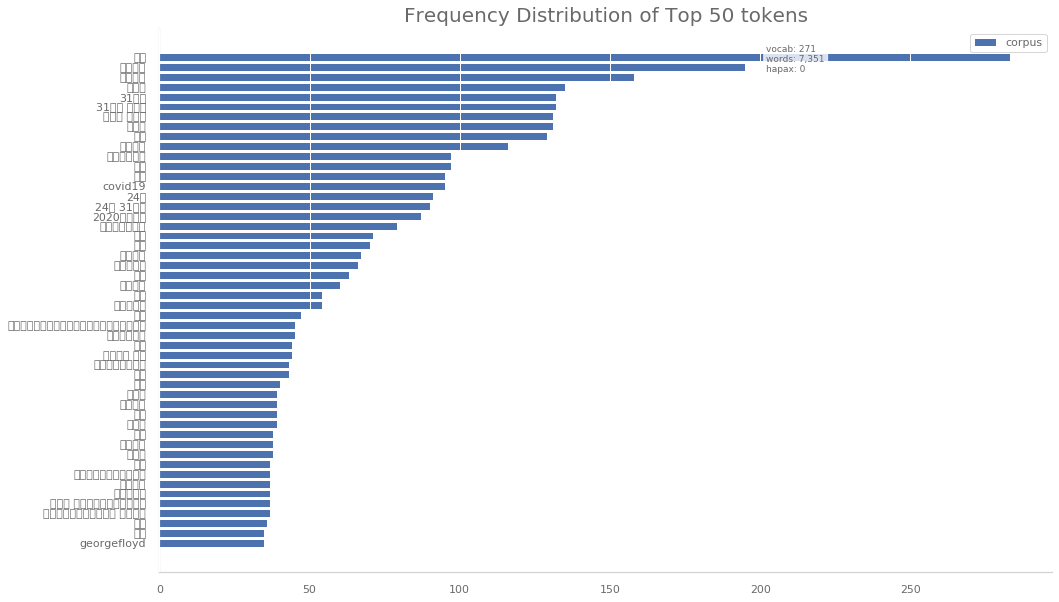

In [46]:
# Visualize frequent terms
import jieba
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer

# change font to chinese
font_dirs = ['/Library/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

plt.rcParams['font.family'] = 'Noto Sans SC'

# clean text
vect = CountVectorizer(min_df=10, ngram_range=(1,2))
docs = vect.fit_transform(zh_df['text_clean'].dropna())
features = vect.get_feature_names()

plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features, show = False)
visualiser.fit(docs)

visualiser.poof('plots/chinese/top50.png')

## Topic modelling

### English

In [5]:
# pyLDAvis
import gensim
import pyLDAvis.gensim
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models, similarities


stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = ' '.join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join([ch for ch in stop_free if ch not in exclude])
    normalized = ' '.join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


# some additional pre-processing is needed, so I'll use the original tweet-text column from the sample instead
sample_text = en_df['text_clean']
state_text = list(sample_text.values)

text_clean = [clean(doc).split() for doc in state_text]
dictionary = corpora.Dictionary(text_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_clean]

# I'm keeping the number of topics small so that they would be easier to discern
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics = 8, id2word = dictionary, passes=100)

In [8]:
tfidf = models.TfidfModel(doc_term_matrix)
doc_tfidf = tfidf[doc_term_matrix]
doc_lda = ldamodel[doc_tfidf]

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(ldamodel, doc_lda, dictionary, mds='tsne', sort_topics=True)
#panel

# save
#pyLDAvis.save_html(panel, '8_topics_english.html')

In [10]:
panel2 = pyLDAvis.gensim.prepare(ldamodel, doc_lda, dictionary, mds='tsne', sort_topics=False)

In [25]:
print(panel.topic_order)
#print(panel2.topic_order)

[3, 2, 6, 1, 8, 7, 4, 5]


In [26]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2     -108.958252 -208.941483       1        1  38.671307
1      186.487061  -98.103249       2        1  18.590992
5       19.245832  160.858780       3        1  11.260161
0      170.658829   75.445076       4        1   6.297363
7       -1.386411  -35.043739       5        1   6.295045
6     -145.800095  106.944611       6        1   6.295045
3       64.834541 -221.825272       7        1   6.295045
4     -196.906036  -58.990913       8        1   6.295042, topic_info=          Term        Freq       Total Category  logprob  loglift
29       china  730.000000  730.000000  Default  30.0000  30.0000
96           u  213.000000  213.000000  Default  29.0000  29.0000
152    covid19  116.000000  116.000000  Default  28.0000  28.0000
275         hk  121.000000  121.000000  Default  27.0000  27.0000
281   security  114.000000  114.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
278   mainland    5.410541   12.487947   Topic8  -5.5168   1.9290
93      people    6.775127  100.380730   Topic8  -5.2919   0.0697
1038    market    5.943842   36.435368   Topic8  -5.4228   0.9522
51           1    5.549261   23.440031   Topic8  -5.4915   1.3246
96           u    5.799859  213.903137   Topic8  -5.4473  -0.8423

[470 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
24        4  0.605996     000
24        7  0.060600     000
24        8  0.302998     000
51        4  0.767917       1
51        8  0.255972       1
...     ...       ...     ...
2331      3  1.031777      yi
779       4  1.042181    yuan
2641      5  1.022995  yunnan
742       3  0.932089    zhao
3914      2  0.959017      香港

[685 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 6, 1, 8, 7, 4, 5])

In [22]:
pyLDAvis.save_html(panel2, 'plots/english/8_topics_english_notsorted.html')

#### Word clouds

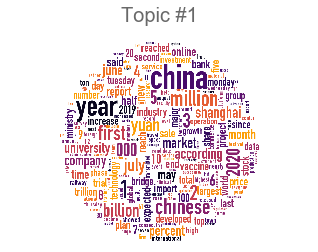

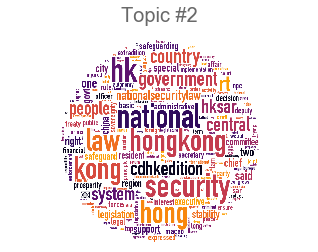

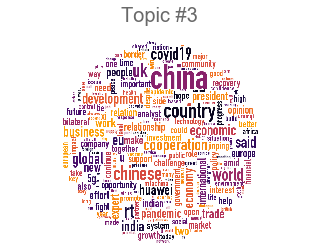

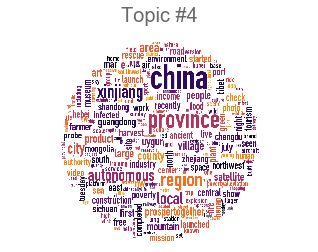

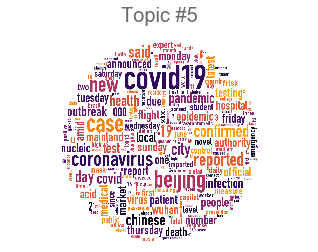

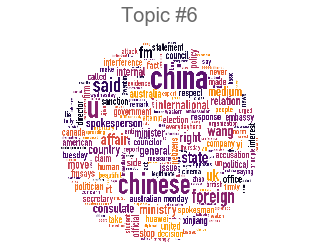

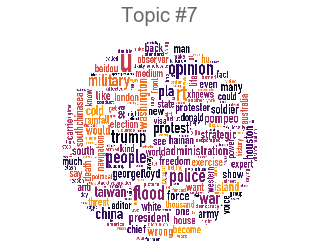

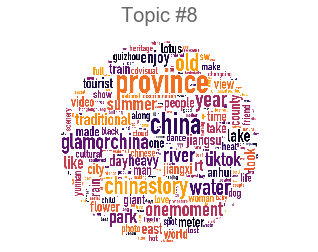

In [29]:
# lda is assumed to be the variable holding the LdaModel object
from wordcloud import WordCloud, STOPWORDS
from palettable.colorbrewer.qualitative import Dark2_8
from palettable.lightbartlein.diverging import BlueDarkOrange18_5
from palettable.matplotlib import Inferno_20
import random
from PIL import Image
import numpy as np

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Inferno_20.colors[random.randint(1,15)])

font_path = "/Library/Fonts/DIN Condensed Bold.ttf"
icon_path = "utils/circle.png"

mask = np.array(Image.open(icon_path))

for t in range(ldamodel.num_topics):
    plt.figure()
    # wordcloud = WordCloud(background_color="white", max_font_size=60, width=800, height=400)
    wc = WordCloud(font_path=font_path, background_color="white", max_words=2000, mask = mask,
               stopwords=STOPWORDS,
               max_font_size=100, random_state=42,
                  width=800, height=400)
    plt.imshow(wc.fit_words(dict(ldamodel.show_topic(t, 200))).recolor(color_func=color_func, random_state=3))
    #wc.recolor(color_func=color_func)
    plt.axis("off")
    plt.title("Topic #" + str(t+1))
    #plt.show()
    plt.savefig(f"plots/english/en_wordcloud_topic_{t+1}.png", dpi = 400)
    


### Chinese

See here for word cloud in chinese: https://amueller.github.io/word_cloud/auto_examples/wordcloud_cn.html

## Drafts
### Cluster analysis

NB!! Change to clean text variables; Change HDBScan parameters!

In [ ]:
# general prep
real_clean = en_df['text']
corpus_clean = list(real_clean.values)
tfidf = TfidfVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
docs_clean = tfidf.fit_transform(corpus_clean)

In [ ]:
# K-Means
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=10)
clusters.fit(docs_clean)
plt.figure(figsize=(16,10))
tsne = TSNEVisualizer()
tsne.fit(docs_clean, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()
plt.show()


In [ ]:
# HDBScan
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(docs_clean)
plt.figure(figsize=(16,10))
tsne = TSNEVisualizer()
tsne.fit(docs_clean, ["c{}".format(c) for c in clusterer.labels_])
tsne.poof()
plt.show()